<a href="https://colab.research.google.com/github/nealm682/DIY-Shopping-List-Builder/blob/main/FINAL_PDF_KnowledgeBase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.4/648.4 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.3/256.3 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 45.4 MB/s eta 0:00:

Saving btac482.pdf to btac482.pdf
User uploaded file "btac482.pdf" with length 336866 bytes


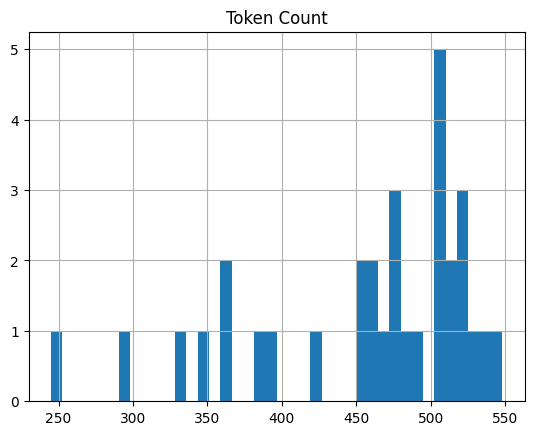

Ask me a question about the PDF document you just uploaded. Type 'exit' to stop.


Text(value='', placeholder='Please enter your question here:')

HTML(value='<b>User:</b> How was ChemBERTaLM model used')

HTML(value='<b><font color="blue">Chatbot:</font></b>  ChemBERTaLM was used to warm-start the targeted generat…

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain
from google.colab import files
from IPython.display import display
import ipywidgets as widgets


# Set API Key
os.environ["OPENAI_API_KEY"] = "<Your api goes here>"


# Request the user to upload a file
uploaded = files.upload()

for fn in uploaded.keys():
  pdf = fn
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


filename = pdf.replace(' ', '-')
filename_text = filename.replace('pdf', 'txt')

# Advanced method - Split by chunk

# Step 1: Convert PDF to text
import textract
doc = textract.process("./"+filename)

# Step 2: Save to .txt and reopen (helps prevent issues)
with open('filename_text', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('filename_text', 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])


# Quick data visualization to ensure chunking was successful
# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()



# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)


# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())


chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""

    if query.lower() == 'exit':
        print("Thank you for using Neal's chatbot!")
        return

    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Ask me a question about the PDF document you just uploaded. Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question here:')
input_box.on_submit(on_submit)

display(input_box)